In [9]:
import os
import sys

cwd = os.getcwd()
project_dir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.append(project_dir)

data_path = os.path.join(project_dir, 'data/')
print(project_dir)
print(data_path)

/home/seuh/Tagging-Music-Sequences
/home/seuh/Tagging-Music-Sequences/data/


In [10]:
import torch
import matplotlib.pyplot as plt

import src.models as models
from src.audio_dataset import get_dataloader
from src.trainer import Trainer

import pandas as pd
import numpy as np

import pickle
import seaborn as sns

from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss

In [11]:
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Trained on gtzan
fcn7_transfer_unfreezed = getattr(models, 'FCN7TransferUnfreezed')
fcn7_transfer_unfreezed = fcn7_transfer_unfreezed().to(device)

fcn7_transfer_2layers = getattr(models, 'FCN7Transfer2Layers')
fcn7_transfer_2layers = fcn7_transfer_2layers().to(device)

fcn7_transfer_1layer = getattr(models, 'FCN7Transfer1Layer')
fcn7_transfer_1layer = fcn7_transfer_1layer().to(device)

In [13]:
# Initialize the Trainer
# Trained with two extra layers, two unfreezed layer
trainer_unfreezed = Trainer(fcn7_transfer_unfreezed, train_loader=None, valid_loader=None, learning_rate=0.001, device=device)
trainer_unfreezed.load_model('../models/FCN7_Transfer_unfreezed_final.pth')

# Trained with two extra layers
trainer_2layers = Trainer(fcn7_transfer_2layers, train_loader=None, valid_loader=None, learning_rate=0.001, device=device)
trainer_2layers.load_model('../models/FCN7_Transfer_2layers_final.pth')

# Trained with one extra layer
trainer_1layer= Trainer(fcn7_transfer_1layer, train_loader=None, valid_loader=None, learning_rate=0.001, device=device)
trainer_1layer.load_model('../models/FCN7_Transfer_final_20231210-1915.pth')


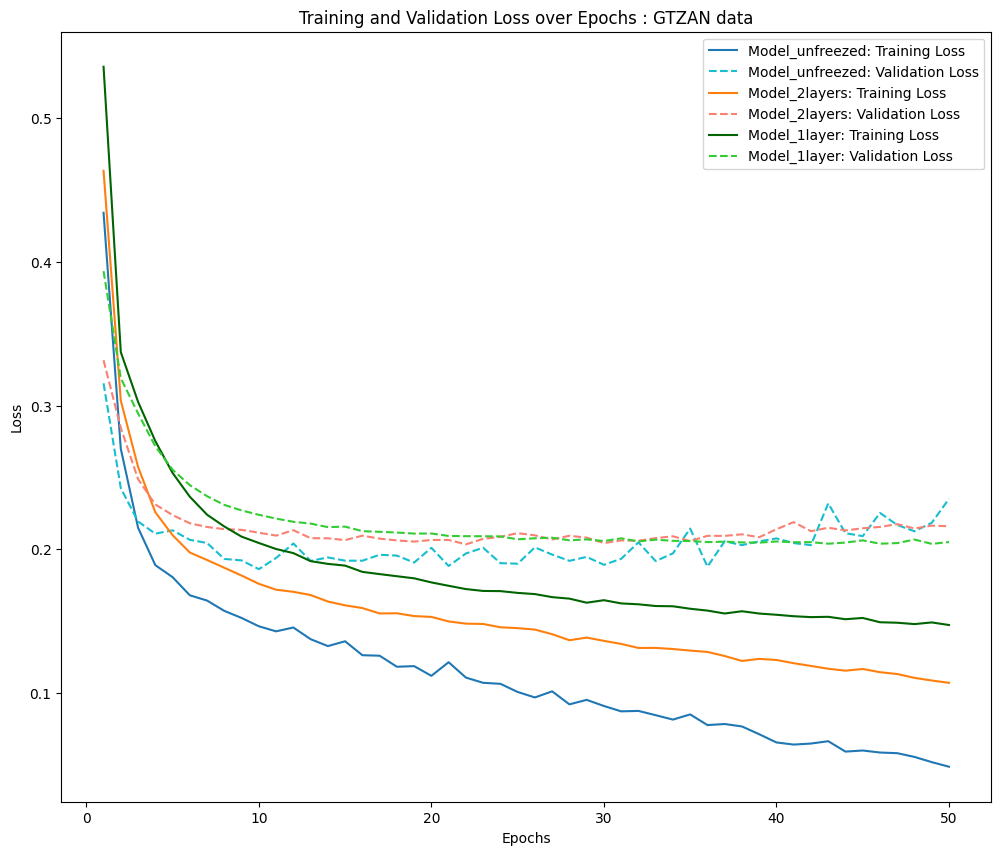

In [15]:
# Models
m = trainer_unfreezed
l = trainer_2layers
p = trainer_1layer

# Epoch range
epochs = range(1, 51) 

plt.figure(figsize=(12, 10))

plt.plot(epochs, m.history['train_loss'], color='#1f77b4', linestyle='-', label='Model_unfreezed: Training Loss')
plt.plot(epochs, m.history['val_loss'], color='#17becf', linestyle='--', label='Model_unfreezed: Validation Loss')


plt.plot(epochs, l.history['train_loss'], color='#ff7f0e', linestyle='-', label='Model_2layers: Training Loss')
plt.plot(epochs, l.history['val_loss'], color='#fa8072', linestyle='--', label='Model_2layers: Validation Loss')


plt.plot(epochs, p.history['train_loss'], color='#006400', linestyle='-', label='Model_1layer: Training Loss')
plt.plot(epochs, p.history['val_loss'], color='#32CD32', linestyle='--', label='Model_1layer: Validation Loss')

plt.title('Training and Validation Loss over Epochs : GTZAN data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


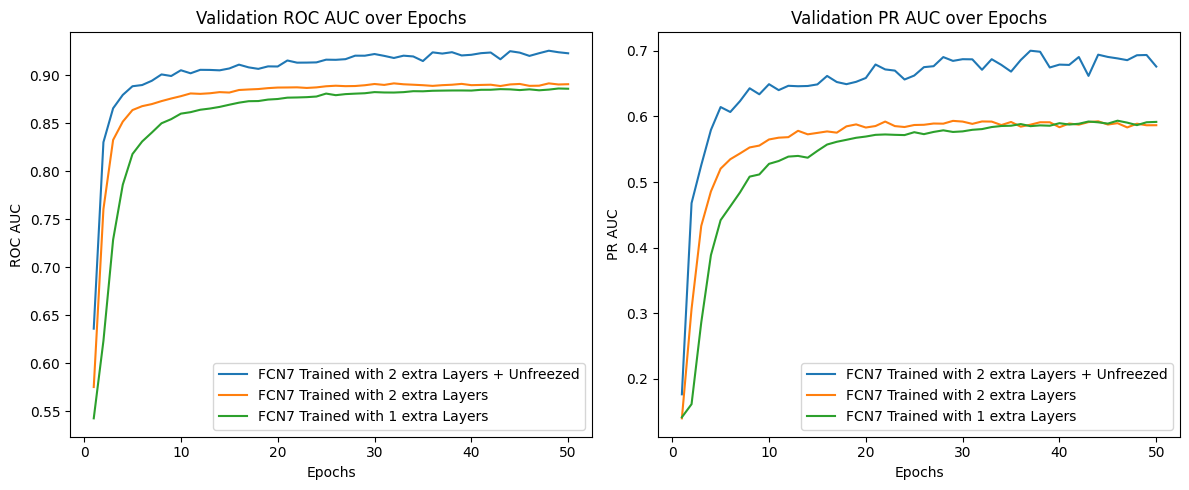

In [8]:
# Sample data
# Replace these with your actual data
epochs = range(1, 51)  # Example epoch range from 1 to 10

# Plotting
plt.figure(figsize=(12, 5))

# Plot for val_roc_auc
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(epochs, m.history['val_roc_auc'], label='FCN7 Trained with 2 extra Layers + Unfreezed')
plt.plot(epochs, l.history['val_roc_auc'], label='FCN7 Trained with 2 extra Layers')
plt.plot(epochs, p.history['val_roc_auc'], label='FCN7 Trained with 1 extra Layers')
plt.title('Validation ROC AUC over Epochs')
plt.xlabel('Epochs')
plt.ylabel('ROC AUC')
plt.legend()

# Plot for val_pr_auc
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(epochs, m.history['val_pr_auc'], label='FCN7 Trained with 2 extra Layers + Unfreezed')
plt.plot(epochs, l.history['val_pr_auc'], label='FCN7 Trained with 2 extra Layers')
plt.plot(epochs, p.history['val_pr_auc'], label='FCN7 Trained with 1 extra Layers')
plt.title('Validation PR AUC over Epochs')
plt.xlabel('Epochs')
plt.ylabel('PR AUC')
plt.legend()

plt.tight_layout()
plt.show()

# Transfer Learning Result Analysis

## 1 Find model to evaluate

###  1.1 ROC AUC, PR AUC, Loss, Accuracy, F1, precision, recall

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(predicted_probs, true_labels):    
    # Converting probabilistic predictions to class predictions
    predicted_labels = np.argmax(predicted_probs, axis=1)
    true_labels = np.argmax(true_labels, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    
    return accuracy, precision, recall, f1

In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# Directory containing pickle files
pickle_dir = '../evaluation_results'

files = [
    'FCN7Transfer1Layer_best.pkl',
    'FCN7Transfer2layers_best.pkl',
    'FCN7TransferUnfreezed_best.pkl',
]


# Initialize empty lists to store data
# avg_loss, roc_auc, pr_auc, predicted_labels, true_labels, filepaths
models, roc_aucs, pr_aucs, average_losses, predicted_labels, true_labels, filepaths, accuracies, precisions, recalls, f1s= [], [], [], [], [], [], [], [], [], [], []

evaluation_results = {}

# Iterate over each file and extract data
for file in files:
    # Extract model name from filename (up to the first underscore)
    model_name = file.split('_')[0]
    
    with open(os.path.join(pickle_dir, file), 'rb') as f:
        evaluation_result = pickle.load(f)
        
    evaluation_results[model_name] = evaluation_result
    
    # Store the data for dataframe
    models.append(model_name)
    roc_aucs.append(evaluation_result[1])
    pr_aucs.append(evaluation_result[2])
    average_losses.append(evaluation_result[0])
    # predicted_labels.append(evaluation_result[3])
    # true_labels.append(evaluation_result[4])
    # filepaths.append(evaluation_result[5])
    concatenated_predicted_probs = np.concatenate(evaluation_result[3])
    concatenated_true_labels = np.concatenate(evaluation_result[4])
    
    # Calculate accuracy, precision, recall, and F1
    accuracy, precision, recall, f1 = calculate_metrics(concatenated_predicted_probs, concatenated_true_labels)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
    

# Creating DataFrame for comparison
evaluation_results_df = pd.DataFrame({
    'Model': models,
    'ROC AUC': roc_aucs,
    'PR AUC': pr_aucs,
    # 'Average Loss': average_losses,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1s
})


print(evaluation_results_df)

                   Model   ROC AUC    PR AUC  Accuracy  Precision    Recall  \
0     FCN7Transfer1Layer  0.892505  0.631282     0.585   0.571113  0.607126   
1    FCN7Transfer2layers  0.890856  0.622516     0.560   0.555471  0.580159   
2  FCN7TransferUnfreezed  0.917804  0.702856     0.620   0.615160  0.628788   

   F1 Score  
0  0.575148  
1  0.557577  
2  0.612846  


### 1.2 Visualisation

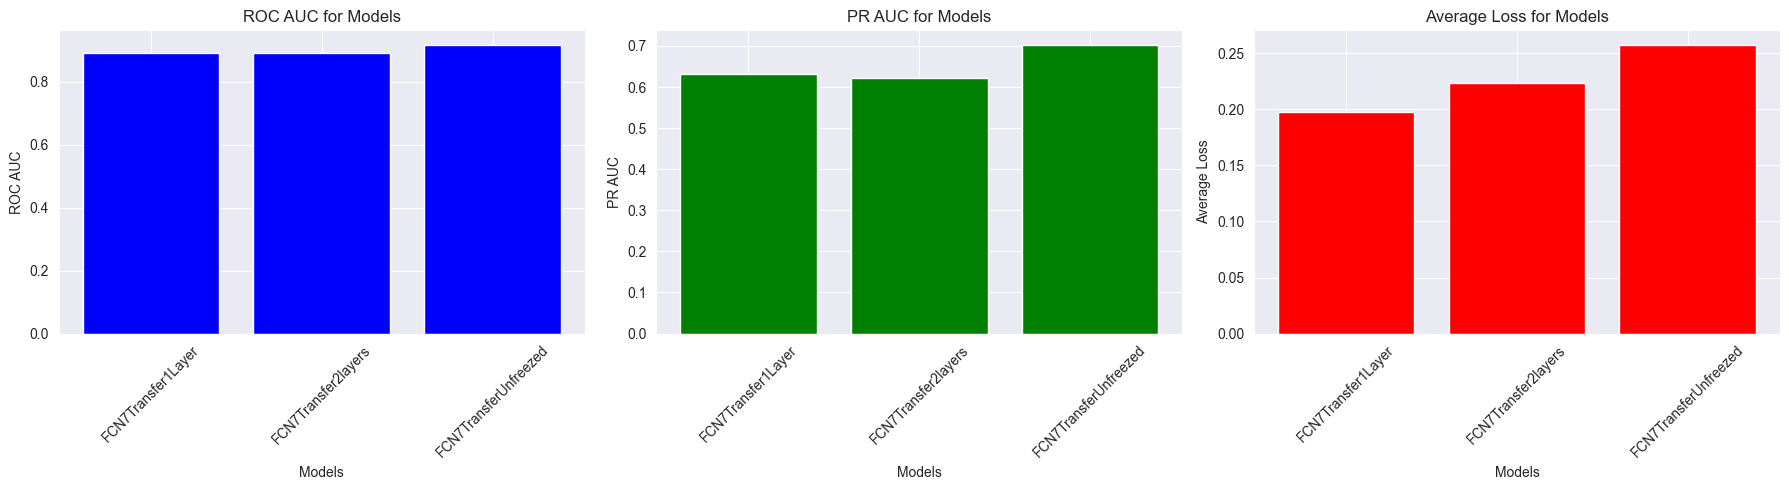

In [22]:
# Plotting
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Set the tick positions and labels for each subplot
for i in range(3):
    ax[i].set_xticks(range(len(models)))
    ax[i].set_xticklabels(models, rotation=45)

# ROC AUC Bar Chart
ax[0].bar(range(len(models)), roc_aucs, color='blue')
ax[0].set_title('ROC AUC for Models')
ax[0].set_xlabel('Models')
ax[0].set_ylabel('ROC AUC')

# PR AUC Bar Chart
ax[1].bar(range(len(models)), pr_aucs, color='green')
ax[1].set_title('PR AUC for Models')
ax[1].set_xlabel('Models')
ax[1].set_ylabel('PR AUC')

# Average Loss Bar Chart
ax[2].bar(range(len(models)), average_losses, color='red')
ax[2].set_title('Average Loss for Models')
ax[2].set_xlabel('Models')
ax[2].set_ylabel('Average Loss')

plt.tight_layout()
plt.show()


### 1.3 Choose model to evaluate

In [66]:
evaluated_model = 'trainer_mel7_l2'

### 1.4 Preprocessing of results
We have to convert the predicted labels from floating point probabilities to a binary array, so it can be compared to the true labels.

In [67]:
# Apply threshold to convert probabilities to binary labels
threshold1 = 0.5

# Ensure predicted_probs is a list of NumPy arrays
predicted_probs_list = evaluation_results[evaluated_model][3]

# Concatenate all predicted probabilities to form a single array
predicted_probs_np = np.concatenate(predicted_probs_list)

# Ensure true_labels is also a list of NumPy arrays
true_labels_list = evaluation_results[evaluated_model][4]

# Concatenate all true labels to form a single array
true_labels = np.concatenate(true_labels_list)

predicted_labels = (predicted_probs_np >= threshold1).astype(int)

# Verify the shapes
assert true_labels.shape == predicted_labels.shape, "Shapes of arrays do not match"

print("Shape of true_labels:", true_labels.shape)
print("Shape of predicted_labels:", predicted_labels.shape)


Shape of true_labels: (4328, 50)
Shape of predicted_labels: (4328, 50)


## 2 Sample Analysis
Analys the worst performing samples.

### 2.1 Subset accuracy
This approach is rather strict, as a sample is only considered to be correctly classified if all predicted labels match the true labels.

In [68]:
# Identifying misclassified samples
misclassified_indices = []
for i in range(len(true_labels)):
    if not np.array_equal(true_labels[i], predicted_labels[i]):
        misclassified_indices.append(i)

# Number of misclassified samples
num_misclassified = len(misclassified_indices)

# Total number of samples
total_samples = len(true_labels)

# Calculate the percentage of misclassified samples
misclassified_percentage = (num_misclassified / total_samples) * 100

# Print the number and percentage of misclassified samples
print(f"Number of misclassified samples by subset accuracy : {num_misclassified} / {total_samples} ({misclassified_percentage:.2f}%)")


Number of misclassified samples by subset accuracy : 3946 / 4328 (91.17%)


### 2.2 Jaccard Similarity
Used to identify samples where the model's prediction significantly diverges from the actual labels. Samples with a Jaccard Similarity below a certain threshold can be considered as edge cases.

In [85]:
# Define a threshold for low Jaccard Similarity
threshold2 = 0.01

def calculate_jaccard_similarity(actual, predicted):
    intersection = np.logical_and(actual, predicted).sum(axis=1)
    union = np.logical_or(actual, predicted).sum(axis=1)
    similarity = np.divide(intersection, union, out=np.zeros_like(intersection, dtype=float), where=(union != 0))
    return similarity

jaccard_similarities = calculate_jaccard_similarity(true_labels, predicted_labels)

# Calculate and print the average Jaccard Similarity
average_jaccard_similarity = np.mean(jaccard_similarities)
print("Number of Jaccard Similarity Scores:", len(jaccard_similarities))
print("Average Jaccard Similarity:", average_jaccard_similarity)

# Identify samples with Jaccard Similarity below the threshold
low_jaccard_indices = [index for index, score in enumerate(jaccard_similarities) if score < threshold2]

# Calculate and print the percentage of samples below the threshold
percentage_low_jaccard = (len(low_jaccard_indices) / len(jaccard_similarities)) * 100
print(f"Samples with Jaccard Similarity below {threshold2}: {len(low_jaccard_indices)} ({percentage_low_jaccard:.2f}%)")


Number of Jaccard Similarity Scores: 4328
Average Jaccard Similarity: 0.3646977957860582
Samples with Jaccard Similarity below 0.01: 990 (22.87%)


### 2.3 Sample F1
To be less strict, we can conduct a smaple-wise evaluation using precision, recall, and F-score.

In [70]:
# Define a threshold for low F1-score
threshold3 = 0.01

# Calculate sample-wise F1-score, Precision, and Recall
sample_f1 = [f1_score(true, pred, average='binary', zero_division=0)
             for true, pred in zip(true_labels, predicted_labels)]

sample_precision = [precision_score(true, pred, average='binary', zero_division=0)
                    for true, pred in zip(true_labels, predicted_labels)]

sample_recall = [recall_score(true, pred, average='binary', zero_division=0)
                 for true, pred in zip(true_labels, predicted_labels)]

# Calculate the average sample-wise scores
sample_f1_average = np.mean(sample_f1)
sample_precision_average = np.mean(sample_precision)
sample_recall_average = np.mean(sample_recall)

# Count the number of samples below the threshold for each metric
num_samples_below_f1_threshold = sum(score < threshold3 for score in sample_f1)
num_samples_below_precision_threshold = sum(score < threshold3 for score in sample_precision)
num_samples_below_recall_threshold = sum(score < threshold3 for score in sample_recall)

# Calculate percentages
percentage_f1_below_threshold = (num_samples_below_f1_threshold / len(sample_f1)) * 100
percentage_precision_below_threshold = (num_samples_below_precision_threshold / len(sample_precision)) * 100
percentage_recall_below_threshold = (num_samples_below_recall_threshold / len(sample_recall)) * 100

low_f1_samples = [index for index, score in enumerate(sample_f1) if score < threshold3]

print(f"Number of Samples: {len(sample_f1)}")
print(f"Average Sample-wise F1-score: {sample_f1_average:.4f}")
print(f"Average Sample-wise Precision: {sample_precision_average:.4f}")
print(f"Average Sample-wise Recall: {sample_recall_average:.4f}")
print(f"Samples with F1-score below {threshold3}: {num_samples_below_f1_threshold} ({percentage_f1_below_threshold:.2f}%)")
print(f"Samples with Precision below {threshold3}: {num_samples_below_precision_threshold} ({percentage_precision_below_threshold:.2f}%)")
print(f"Samples with Recall below {threshold3}: {num_samples_below_recall_threshold} ({percentage_recall_below_threshold:.2f}%)")


Number of Samples: 4328
Average Sample-wise F1-score: 0.4687
Average Sample-wise Precision: 0.6149
Average Sample-wise Recall: 0.4499
Samples with F1-score below 0.01: 990 (22.87%)
Samples with Precision below 0.01: 990 (22.87%)
Samples with Recall below 0.01: 990 (22.87%)


### 2.4 Low Jaccard and F1
Find samples that have bad scores in both, jaccard score and F1.

In [71]:
# Convert the lists to sets for efficient intersection operation
low_jaccard_set = set(low_jaccard_indices)
low_f1_samples_set = set(low_f1_samples)

# Find the intersection of the two sets to get indices present in both lists
edge_cases_samples_indices = low_jaccard_set.intersection(low_f1_samples_set)

# Count the number of common indices and calculate the percentage
num_common_indices_labels = len(edge_cases_samples_indices)
percentage_common_labels = (num_common_indices_labels / len(true_labels)) * 100

# Format the output
print(f"Number of samples: {len(true_labels)}")
print(f"Samples with both low Jaccard Similarity and low F1-score: {num_common_indices_labels} ({percentage_common_labels:.2f}%)")
print("\nIndices:")
print(sorted(edge_cases_samples_indices))

Number of samples: 4328
Samples with both low Jaccard Similarity and low F1-score: 990 (22.87%)

Indices:
[13, 19, 23, 30, 32, 35, 36, 49, 55, 57, 61, 62, 66, 71, 72, 73, 79, 88, 90, 106, 117, 129, 136, 140, 144, 146, 148, 149, 151, 158, 162, 165, 166, 167, 172, 177, 178, 179, 180, 183, 188, 191, 192, 193, 199, 201, 202, 204, 208, 209, 211, 214, 217, 218, 221, 225, 232, 239, 242, 246, 248, 260, 264, 270, 272, 273, 277, 282, 289, 290, 291, 293, 298, 299, 310, 312, 315, 319, 321, 323, 326, 327, 344, 348, 349, 355, 356, 362, 364, 371, 372, 373, 375, 387, 389, 400, 401, 404, 411, 412, 414, 415, 425, 434, 442, 452, 462, 463, 464, 468, 476, 483, 486, 488, 493, 496, 508, 522, 536, 542, 547, 552, 555, 562, 564, 565, 569, 570, 572, 583, 585, 589, 592, 594, 599, 600, 607, 612, 616, 621, 624, 627, 629, 633, 640, 648, 651, 652, 662, 670, 673, 676, 678, 679, 688, 689, 692, 693, 700, 703, 716, 718, 724, 728, 734, 735, 750, 752, 756, 761, 763, 767, 771, 772, 775, 779, 783, 785, 787, 797, 805, 808, 81

### 2.5 Inspect Samples

In [72]:
# Extract the column containing file paths
file_path_samples = np.concatenate(evaluation_results[evaluated_model][5])

# Retrieve the file paths for the indices in sample_edge_cases
sample_edge_cases_files = [file_path_samples[index] for index in sorted(edge_cases_samples_indices)]
print(f"Edge case samples: \n{sample_edge_cases_files}")

Edge case samples: 
['../data/mtat/5/stargarden-the_art_of_analog_diversion-02-trybal-88-117.mp3', '../data/mtat/7/wicked_boy-the_treatment-01-pressure-59-88.mp3', '../data/mtat/b/dj_cary-power_synths-01-call_me_snake_dr_kuch-0-29.mp3', '../data/mtat/2/magnatune_compilation-electronica-12-mr_epic_down_low-88-117.mp3', '../data/mtat/f/the_headroom_project-jetuton_andawai-06-manu_yu-88-117.mp3', '../data/mtat/2/maryse_carlin-rameau__pieces_de_clavecin_en_concerts__forqueray_suites_4_and_5-11-fourth_suite__la_bournonville_forqueray-59-88.mp3', '../data/mtat/b/dj_cary-power_synths-03-from_love_2_wicked_allstars-30-59.mp3', '../data/mtat/1/tim_rayborn-qadim-09-dosaram__tar_persian-291-320.mp3', '../data/mtat/c/jay_kishor-cd2_the_sowebo_concert-01-raga_malkauns-1074-1103.mp3', '../data/mtat/b/liquid_zen-elements_at_loop_10-09-painted_angels-233-262.mp3', '../data/mtat/b/suzanne_teng-miles_beyond-01-medicine_wheel-204-233.mp3', '../data/mtat/2/saros-soundscapes-02-sunrise-291-320.mp3', '../da

In [73]:
# Worth it to inspect the audio files?

## 3 Label Analysis
Analys labels the model finds hard to predict for potential edge cases.

In [74]:
# Load labels file
train_labels_df = pd.read_csv('../data/mtat_train_label.csv')

# Drop the first column (Unnamed: 0) and the last column ('filepath')
# The model only uses the labels and not the first and last column of the csv
train_labels_df.drop(columns=['Unnamed: 0', 'filepath'], inplace=True)

# Convert all boolean columns to integers
train_labels_df = train_labels_df.astype(int)

### 3.1 Hamming Loss
Used to understand which labels are most frequently misclassified across all samples. Labels with a high contribution to the Hamming Loss could be a sign for potential edge cases.

In [75]:
# Define a threshold for high Hamming Loss
threshold4 = 0.1

# Calculate the number of labels
num_labels = true_labels.shape[1]
print(f"Number of labels: {num_labels}")

# Calculate the average Hamming Loss for the dataset
avg_hamming_loss = hamming_loss(true_labels, predicted_labels)
print(f"Average Hamming Loss: {avg_hamming_loss:.4f}")

# Identify labels with Hamming Loss exceeding the threshold
high_hamming_loss_labels = []
for label_index in range(num_labels):
    # Calculate Hamming loss for each label
    hamming_loss_label = hamming_loss(true_labels[:, label_index], predicted_labels[:, label_index])
    if hamming_loss_label > threshold4:
        high_hamming_loss_labels.append(label_index)

# Count the number and calculate the percentage of labels with high Hamming Loss
num_high_hamming_loss = len(high_hamming_loss_labels)
percentage_high_hamming_loss = (num_high_hamming_loss / num_labels) * 100
print(f"Labels with Hamming Loss above {threshold4}: {num_high_hamming_loss} / {num_labels} ({percentage_high_hamming_loss:.2f}%)")

print("\nIndices of labels with high hamming loss:")
print(high_hamming_loss_labels)


Number of labels: 50
Average Hamming Loss: 0.0519
Labels with Hamming Loss above 0.1: 9 / 50 (18.00%)

Indices of labels with high hamming loss:
[0, 1, 2, 4, 5, 6, 7, 8, 10]


In [76]:
# Convert the set to a sorted list
high_hamming_loss_labels_sorted = sorted(list(high_hamming_loss_labels))

# Extracting label names
high_hamming_loss_labels_clear = train_labels_df.columns[high_hamming_loss_labels_sorted]

# Format the output
print(f"Labels with high Hamming loss: \n{high_hamming_loss_labels_clear.tolist()}")

Labels with high Hamming loss: 
['guitar', 'classical', 'slow', 'string', 'vocal', 'electro', 'drum', 'no singer', 'fast']


The Hamming Loss edge case analysis is based on the average Hamming Loss and the defined threshold. n average Hamming loss of 0.0540 (or 5.40%) indicates that, on average, about 5.4% of the labels are incorrectly predicted across all samples, which could be considered a baseline. Setting the threshold to a value such as 0.1 seems like a sensible approach to idntify edge cases, as it means these labels have a Hamming Loss double as high as the average.

### 3.2 Label F1
To be less strict, we can conduct a label-wise evaluation using precision, recall, and F-score.

In [86]:
# Define a threshold for low F1-score
threshold5 = 0.01

# Calculate F1-score, Precision, and Recall for each label
label_f1 = f1_score(true_labels, predicted_labels, average=None, zero_division=0)
label_precision = precision_score(true_labels, predicted_labels, average=None, zero_division=0)
label_recall = recall_score(true_labels, predicted_labels, average=None, zero_division=0)

# Calculate the average scores
average_f1_average = np.mean(label_f1)
label_precision_average = np.mean(label_precision)
label_recall_average = np.mean(label_recall)

print(f"Number of labels: {len(label_f1)}")
print(f"Average F1-score: {average_f1_average:.4f}")
print(f"Average Precision: {label_precision_average:.4f}")
print(f"Average Recall: {label_recall_average:.4f}")

# Identify labels with F1-score below the threshold
low_f1_labels = [label_index for label_index, score in enumerate(label_f1) if score < threshold5]

# Count the number and calculate the percentage of labels with low F1-score
num_low_f1 = len(low_f1_labels)
percentage_low_f1 = (num_low_f1 / len(label_f1)) * 100
print(f"Labels with F1-score below {threshold5}: {num_low_f1} ({percentage_low_f1:.2f}%)")

print("\nIndices of labels with low F1-Score:")
print(low_f1_labels)

low_precision_labels = [label_index for label_index, score in enumerate(label_precision) if score < threshold5]
low_recall_labels = [label_index for label_index, score in enumerate(label_recall) if score < threshold5]

# Print indices of labels with low precision and recall
print("\nIndices of labels with low Precision:")
print(low_precision_labels)

print("\nIndices of labels with low Recall:")
print(low_recall_labels)


Number of labels: 50
Average F1-score: 0.3178
Average Precision: 0.4686
Average Recall: 0.2757
Labels with F1-score below 0.01: 12 (24.00%)

Indices of labels with low F1-Score:
[8, 28, 30, 32, 39, 40, 41, 44, 46, 47, 48, 49]

Indices of labels with low Precision:
[8, 28, 30, 32, 39, 40, 41, 44, 46, 47, 48, 49]

Indices of labels with low Recall:
[8, 28, 30, 32, 39, 40, 41, 44, 46, 47, 48, 49]


In [78]:
# Convert the set to a sorted list
low_f1_labels_sorted = sorted(list(low_f1_labels))

# Extracting label names
low_f1_labels_clear = train_labels_df.columns[low_f1_labels_sorted]

# Format the output
print(f"Labels with low F1-score: \n{low_f1_labels_clear.tolist()}")


Labels with low F1-score: 
['no singer', 'solo', 'new age', 'strange', 'bass', 'modern', 'no piano', 'baroque', 'foreign', 'trance', 'folk', 'no beat']


### 3.3 Hamming Loss and F1
Labels that have high Hamming Loss and low F1-Score

In [79]:
# Convert the lists to sets for efficient intersection operation
high_hamming_loss_labels_set = set(high_hamming_loss_labels)
low_f1_labels_set = set(low_f1_labels)

# Find the intersection of the two sets to get indices present in both lists
combination_labels_indices = high_hamming_loss_labels_set.intersection(low_f1_labels_set)

# Count the number of common indices and calculate the percentage
num_common_indices_labels = len(combination_labels_indices)
percentage_common_labels = (num_common_indices_labels / len(true_labels)) * 100

# Format the output
print(f"Number of labels: {true_labels.shape[1]}")
print(f"Labels with both high Hamming loss and low F1-score: {num_common_indices_labels} ({percentage_common_labels:.2f}%)")
print("\nIndices with high Hamming Loss and low F1-Score:")
print(sorted(combination_labels_indices))


Number of labels: 50
Labels with both high Hamming loss and low F1-score: 1 (0.02%)

Indices with high Hamming Loss and low F1-Score:
[8]


In [80]:
# Convert the set to a sorted list
edge_cases_labels_indices_list = sorted(list(combination_labels_indices))

# Extracting label names
combination_labels_clear = train_labels_df.columns[edge_cases_labels_indices_list]

# Format the output
print(f"Labels with both high Hamming loss and low F1-score: \n{combination_labels_clear.tolist()}")


Labels with both high Hamming loss and low F1-score: 
['no singer']


### 3.4 Statistical Analysis
I need to inspect the train data and not the test data.

In [81]:
# Count the number of rows with each label
label_counts = train_labels_df.sum(axis=0)

# Display the label counts for all labels
label_counts

guitar         2902
classical      2627
slow           2082
techno         1780
string         1716
vocal          1705
electro        1680
drum           1624
no singer      1537
rock           1430
fast           1376
male           1339
beat           1238
female         1227
piano          1233
ambient        1173
violin         1150
synth          1035
india           828
singer          797
opera           776
harpsichord     654
loud            657
quiet           655
flute           597
pop             582
soft            602
sitar           556
solo            472
choir           486
new age         390
dance           363
strange         389
harp            389
heavy           355
cello           321
jazz            348
country         310
eastern         257
bass            207
modern          202
no piano        204
hard            196
chant           194
baroque         182
orchestra       180
foreign         163
trance          153
folk            155
no beat         127


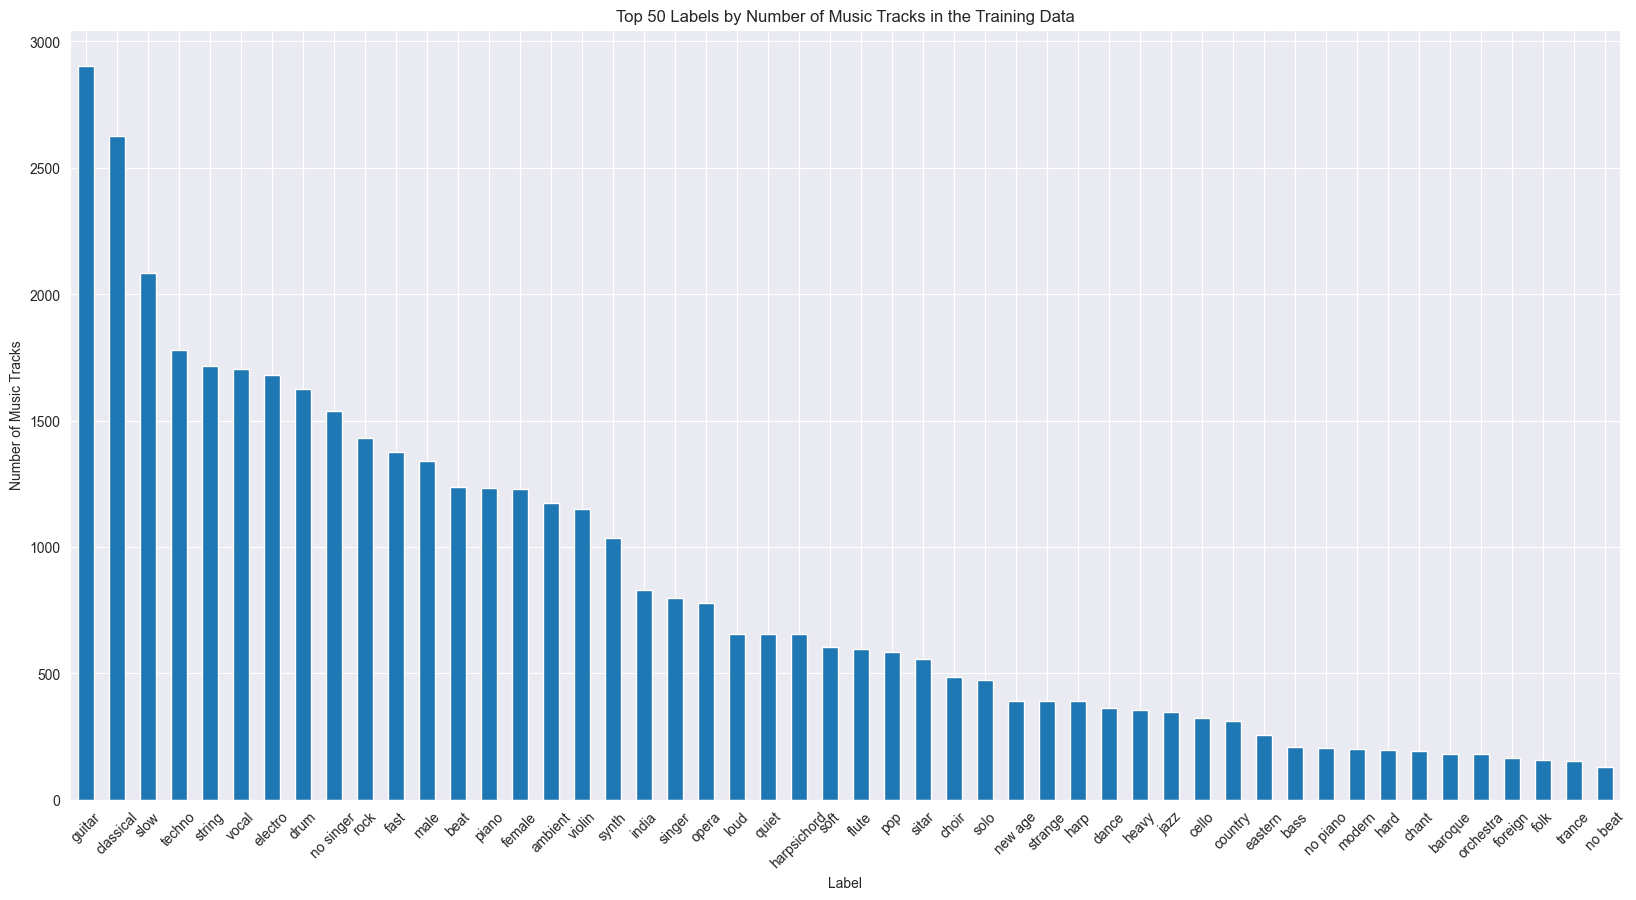

In [82]:
# Plot the labels and their frequency distribution
plt.figure(figsize=(20, 10))
label_counts.sort_values(ascending=False).plot(kind='bar')

plt.title('Top 50 Labels by Number of Music Tracks in the Training Data')
plt.xticks(rotation=45)
plt.ylabel('Number of Music Tracks')
plt.xlabel('Label')

plt.show()

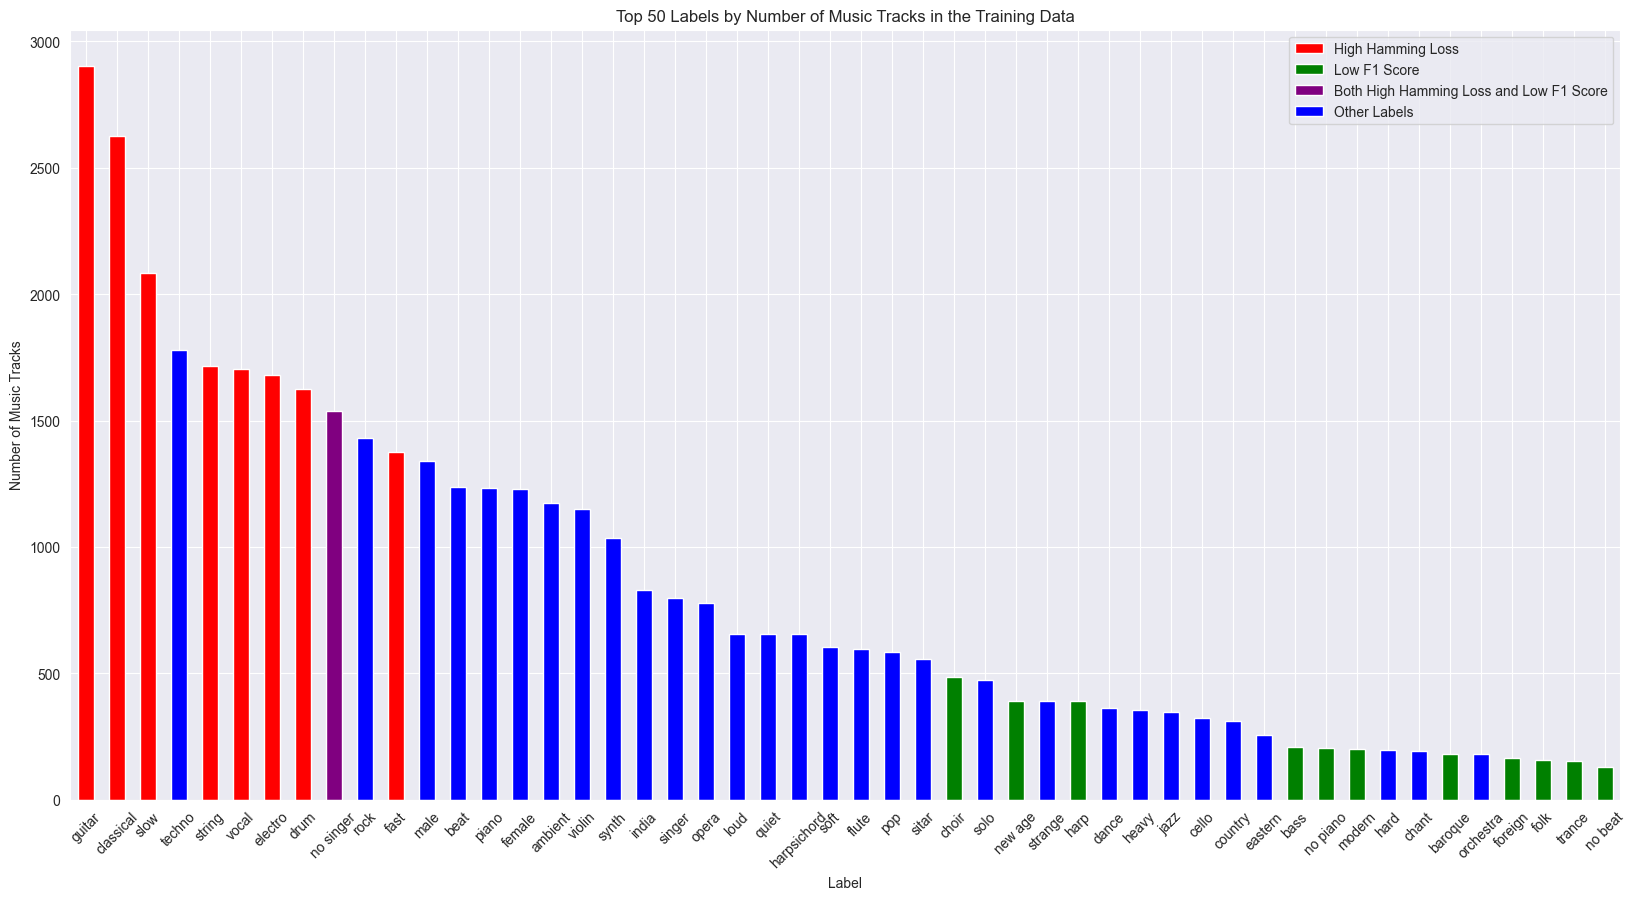

In [83]:
# `train_labels_df` is a DataFrame similar to `test_labels_df` with the same structure but for the training set.
# `label_counts` is a Series obtained from `train_labels_df.sum(axis=0)`.

# Assign colors to each label based on the category it belongs to
colors = []
for label in label_counts.index:
    if label in combination_labels_clear:
        colors.append('purple')  # Both high hamming loss and low f1 score
    elif label in high_hamming_loss_labels_clear:
        colors.append('red')  # High hamming loss
    elif label in low_f1_labels_clear:
        colors.append('green')  # Low f1 score
    else:
        colors.append('blue')  # Default color

# Plot the labels with the assigned colors
plt.figure(figsize=(20, 10))
label_counts.sort_values(ascending=False).plot(kind='bar', color=colors)

# Add title and labels
plt.title('Top 50 Labels by Number of Music Tracks in the Training Data')
plt.xticks(rotation=45)
plt.ylabel('Number of Music Tracks')
plt.xlabel('Label')

# Create a custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', label='High Hamming Loss'),
    Patch(facecolor='green', label='Low F1 Score'),
    Patch(facecolor='purple', label='Both High Hamming Loss and Low F1 Score'),
    Patch(facecolor='blue', label='Other Labels')
]
plt.legend(handles=legend_elements, loc='upper right')

# Show the plot
plt.show()


### 3.5 Correlation

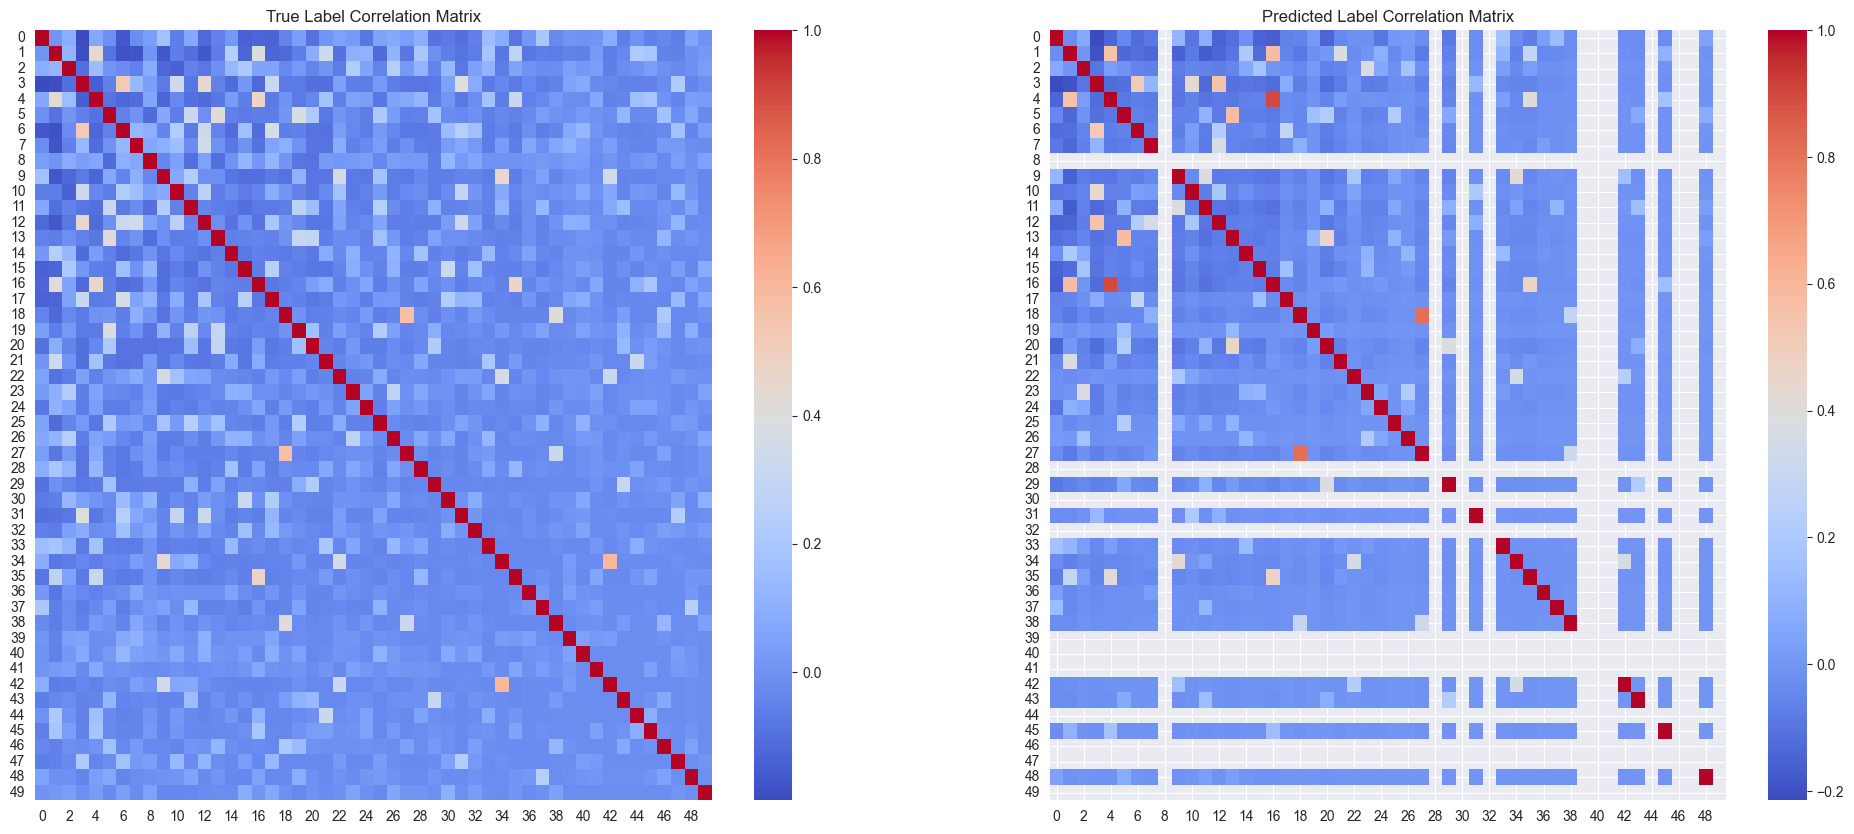

In [84]:
# Assuming true_labels and predicted_labels are your datasets
true_label_corr = pd.DataFrame(true_labels).corr()
predicted_label_corr = pd.DataFrame(predicted_labels).corr()

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(24, 10))
sns.heatmap(true_label_corr, ax=ax[0], cmap='coolwarm')
ax[0].set_title('True Label Correlation Matrix')
sns.heatmap(predicted_label_corr, ax=ax[1], cmap='coolwarm')
ax[1].set_title('Predicted Label Correlation Matrix')
plt.show()
